In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import tensorflow as tf
import pandas as pd
np.set_printoptions(linewidth=500,precision=2,suppress=True)
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable


2023-01-24 09:49:17.897685: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class Model1(tf.keras.Model):

    def __init__(self, dimout):
        super().__init__()
        self.layer1=tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same')
        #self.dropout1=tf.keras.layers.Dropout(0.25)
        self.layer2=tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')
        self.layer3=tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu', padding='same')
        self.layer4=tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')
        self.layer5=tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same')

        self.flatten=tf.keras.layers.Flatten()
        self.dense1=tf.keras.layers.Dense(1024,activation='relu')
        self.dense2=tf.keras.layers.Dense(512,activation='relu')
        self.dense3=tf.keras.layers.Dense(dimout)
        print(f"Dim out = {dimout}")

        self.max_pool=tf.keras.layers.MaxPooling2D(pool_size=(2, 2))


    @tf.function
    def call(self,X,training=True):

        out=self.layer1(X)
        #out=self.dropout1(out, training)
        out=self.max_pool(out)
        out=self.layer2(out)
        out=self.max_pool(out)
        out=self.layer3(out)
        out=self.max_pool(out)
        out=self.layer4(out)
        out=self.max_pool(out)
        out=self.layer5(out)
        out=self.max_pool(out)

        out=self.flatten(out)

        out=self.dense1(out)
        out=self.dense2(out)
        
        return self.dense3(out)


In [8]:
import random

def noisy_data(data, SNR) :
    data_noisy = np.copy(data)
    for i in range(data.shape[0]) :
        max_int = np.max(data[i])
        noise = np.random.normal(0, 1, (data.shape[1], data.shape[2]))
        noise = noise / np.max(noise) * max_int/SNR
        data_noisy[i] = data[i] + np.reshape(noise, (data.shape[1], data.shape[2],1))
    return data_noisy

In [2]:
catalog='../Data/ImageCat.txt'
filename=np.genfromtxt(catalog,skip_header=1,dtype='U60',usecols=0)
data=np.genfromtxt(catalog,skip_header =1, usecols=[1,2,3,4,5,6,7])  #filename	log(M/M_sun)	r_2/kpc	n	q=b/a	p=c/b	phi/pi	theta/pi

In [3]:
logM = np.copy(data[:,0])
R    = np.copy(data[:,1])
n    = np.copy(data[:,2])
q    = np.copy(data[:,3])
p    = np.copy(data[:,4])
phi  = np.copy(data[:,5])
theta= np.copy(data[:,6])

R4  = R/4.
n10 = n/10.

Text(0, 0.5, '#')

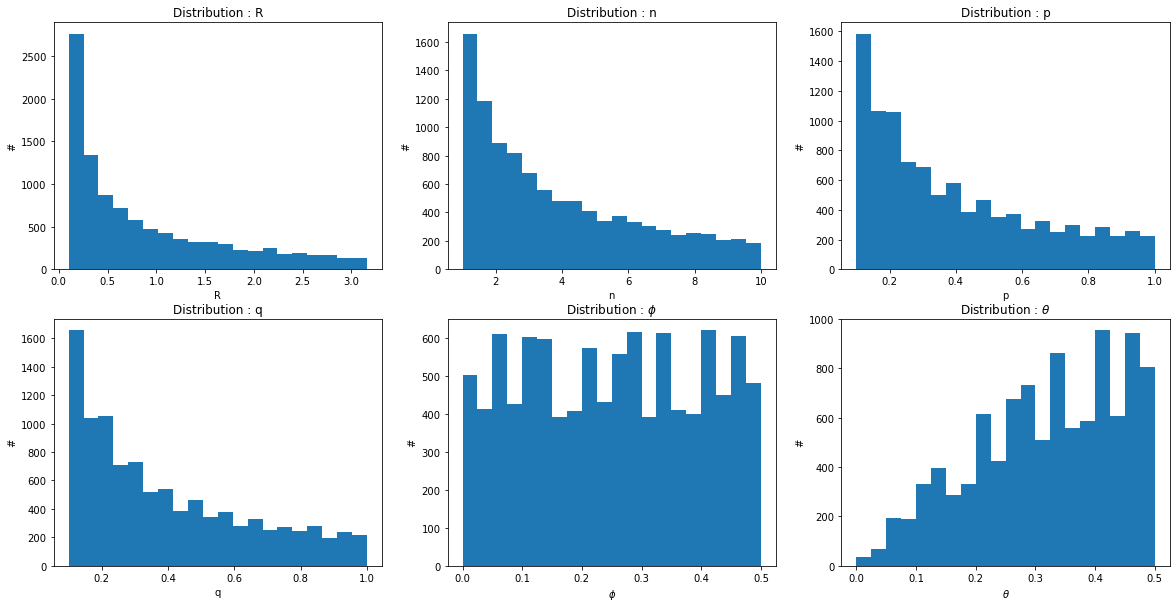

In [6]:
fig, ax = plt.subplots(2,3, figsize = (20,10))
ax[0][0].hist(R, 20)
ax[0][0].set_title('Distribution : R')
ax[0][0].set_xlabel('R')
ax[0][0].set_ylabel('#')

ax[0][1].hist(n, 20)
ax[0][1].set_title('Distribution : n')
ax[0][1].set_xlabel('n')
ax[0][1].set_ylabel('#')

ax[0][2].hist(p, 20)
ax[0][2].set_title('Distribution : p')
ax[0][2].set_xlabel('p')
ax[0][2].set_ylabel('#')

ax[1][0].hist(q, 20)
ax[1][0].set_title('Distribution : q')
ax[1][0].set_xlabel('q')
ax[1][0].set_ylabel('#')

ax[1][1].hist(phi, 20)
ax[1][1].set_title('Distribution : $\phi$')
ax[1][1].set_xlabel('$\phi$')
ax[1][1].set_ylabel('#')

ax[1][2].hist(theta, 20)
ax[1][2].set_title(r'Distribution : $\theta$')
ax[1][2].set_xlabel(r'$\theta$')
ax[1][2].set_ylabel('#')

#plt.savefig('para_distrib.png', dpi=100)

In [4]:
Y = np.stack([R4, n10, q, p, phi, theta],axis=1)
Y = Y.astype('float32')

Y_without_norm = np.stack([R, n, q, p, phi, theta],axis=1)
Y_without_norm = Y_without_norm.astype('float32')
Y.shape, Y.dtype

((10120, 6), dtype('float32'))

In [5]:
D1 = np.load('../Data/IMAGE/'+ filename[1])['imT']
D1.shape

(100, 100)

In [6]:
size = Y.shape[0] 
Y = Y[:size]
D=np.zeros((size,D1.shape[0],D1.shape[0],1)) 
for i in range(size):

    Di=np.load('../Data/IMAGE/'+ filename[i])  
    imTi=np.log10(Di['imT'])
    imTi_min=imTi[imTi>0.].min()
    imTi_max=np.amax(imTi)
    imTi[imTi<0.]=imTi_min
    D[i,:,:,0]=imTi

D = D.astype('float32') 


ngal=np.shape(D)[0]
print("The catalog comprises %i galaxies"%ngal)

The catalog comprises 10120 galaxies


[0.79 0.14 0.38 0.33 0.17 0.21]


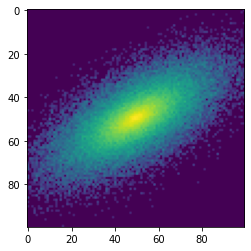

In [7]:
#Relancer plusieurs fois la cellule pour voir que l'on permute aléatoirement les données
shuffle= np.arange(D.shape[0])
np.random.shuffle(shuffle)

Y = Y[shuffle]
D = D[shuffle]

print(Y[100])
plt.imshow(D[100,:,:,0]);

In [10]:
D_noisy = noisy_data(D, 10)

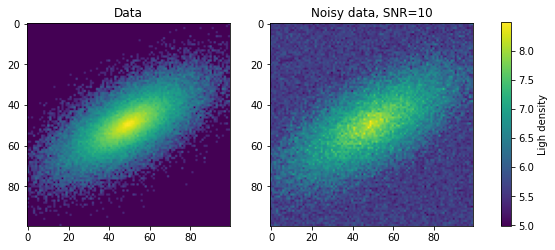

In [19]:
fig, ax = plt.subplots(1,2, figsize = (10,5))

im = ax[0].imshow(D[100,:,:,0])
im = ax[1].imshow(D_noisy[100,:,:,0])

ax[0].set_title('Data')
ax[1].set_title('Noisy data, SNR=10')

fig.colorbar(im, ax=ax, orientation='vertical', label='Ligh density', shrink =0.75)

#plt.savefig('data_and_noise.png', dpi=100)

In [11]:
res_data = pd.DataFrame()

l = len(D)
train_size = int(0.7 * l)
val_size = int(0.15 * l)

X_train = D[:train_size]
Y_train = Y[:train_size]
Y_train_without_norm = Y_without_norm[:train_size]

X_val = D[train_size:train_size+val_size]
Y_val = Y[train_size:train_size+val_size]
Y_val_without_norm = Y_without_norm[train_size:train_size+val_size]

X_test = D[train_size+val_size:]
Y_test = Y[train_size+val_size:]
Y_test_without_norm = Y_without_norm[train_size+val_size:]


In [12]:
Y_train_n = Y_train[:,1]
Y_train_n = Y_train_n[:, None]

Y_val_n = Y_val[:, 1]
Y_val_n = Y_val_n[:, None]

Y_test_n = Y_test[:, 1]
Y_test_n = Y_test_n[:, None]

In [13]:
SNR = 50
X_train_noisy = noisy_data(X_train, SNR)
X_val_noisy = noisy_data(X_val, SNR)
X_test_noisy = noisy_data(X_test, SNR)
model50 = Model1(1)

# Restore the weights
model50.load_weights('./noisy_checkpoints/my_noisy_checkpoint')
model50.compile(
    optimizer=tf.optimizers.Adam(1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['accuracy'] )

# Evaluate the model
loss, acc = model50.evaluate(X_train_noisy, Y_train_n, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

Y_pred_n_noisy50 = model50(X_test_noisy)

2023-01-23 14:50:01.570992: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Dim out = 1
222/222 - 10s - loss: 0.0034 - accuracy: 4.2349e-04 - 10s/epoch - 47ms/step
Restored model, accuracy:  0.04%


In [14]:
from sklearn.metrics import mean_squared_error

rmse50 = np.sqrt(mean_squared_error(Y_test_n, Y_pred_n_noisy50))

In [15]:
rmse50

0.058835763

In [16]:
SNR = 5
X_train_noisy = noisy_data(X_train, SNR)
X_val_noisy = noisy_data(X_val, SNR)
X_test_noisy = noisy_data(X_test, SNR)

model5 = Model1(1)

# Restore the weights
model5.load_weights('./noisy_checkpoints_SNR_5/my_noisy_checkpoint_5')
model5.compile(
    optimizer=tf.optimizers.Adam(1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['accuracy'] )

# Evaluate the model
loss, acc = model5.evaluate(X_train, Y_train_n, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

Y_pred_n_noisy5 = model5(X_test_noisy)

rmse5 = np.sqrt(mean_squared_error(Y_test_n, Y_pred_n_noisy5))

Dim out = 1
222/222 - 9s - loss: 0.0252 - accuracy: 4.2349e-04 - 9s/epoch - 43ms/step
Restored model, accuracy:  0.04%


In [34]:
SNR = 10
X_train_noisy = noisy_data(X_train, SNR)
X_val_noisy = noisy_data(X_val, SNR)
X_test_noisy = noisy_data(X_test, SNR)

model10 = Model1(1)

# Restore the weights
model10.load_weights('./noisy_checkpoints_SNR10/my_noisy_checkpoint_10')
model10.compile(
    optimizer=tf.optimizers.Adam(1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['accuracy'] )

# Evaluate the model
loss, acc = model5.evaluate(X_train_noisy, Y_train_n, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

Y_pred_n_noisy10 = model10(X_test_noisy)

rmse10 = np.sqrt(mean_squared_error(Y_test_n, Y_pred_n_noisy10))

Dim out = 1
222/222 - 10s - loss: 0.0180 - accuracy: 4.2349e-04 - 10s/epoch - 44ms/step
Restored model, accuracy:  0.04%


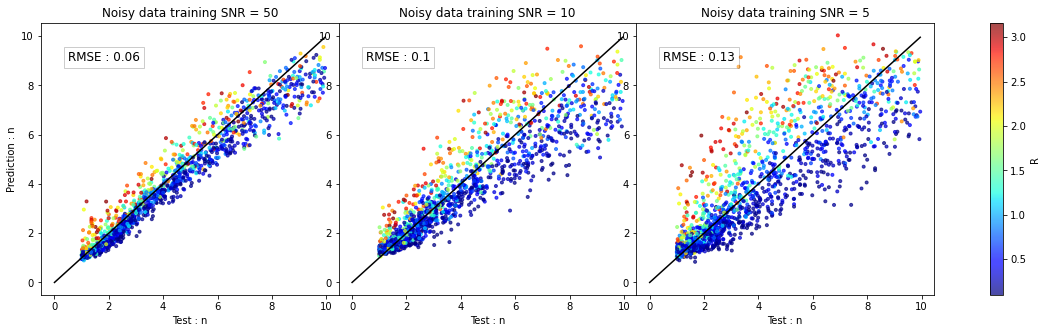

In [21]:
fig, ax =  plt.subplots(1,3, figsize = (20,5))

SNR = 50
ax[0] = plt.subplot2grid((1, 3), (0, 0), colspan=1)
ax[0].set_title("Noisy data training SNR = %s"%SNR)
im = ax[0].scatter(Y_test_n[:,0]*10,Y_pred_n_noisy50[:,0]*10,c=Y_test[:,0]*4,edgecolors=None,alpha=0.7,marker='.',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_n[:,0])*10,1000)
ax[0].plot(abscisse, abscisse, 'k')
ax[0].set_xlabel('Test : n')
ax[0].set_ylabel('Prediction : n')
ax[0].text(0.5, 9, 'RMSE : %s'%np.round(rmse50,2), fontsize=12,
          bbox=dict(facecolor='white', alpha=0.2))

SNR = 10
ax[1] = plt.subplot2grid((1, 3), (0, 1), colspan=1, sharey=ax[0])
ax[1].set_title("Noisy data training SNR = %s"%SNR)
im = ax[1].scatter(Y_test_n[:,0]*10,Y_pred_n_noisy10[:,0]*10,c=Y_test[:,0]*4,edgecolors=None,alpha=0.7,marker='.',cmap='jet')
ax[1].plot(abscisse, abscisse, 'k')
ax[1].set_xlabel('Test : n')
ax[1].text(0.5, 9, 'RMSE : %s'%np.round(rmse10,2), fontsize=12,
          bbox=dict(facecolor='white', alpha=0.2))

SNR = 5
ax[2] = plt.subplot2grid((1, 3), (0, 2), colspan=1, sharey=ax[0])
ax[2].set_title("Noisy data training SNR = %s"%SNR)
im = ax[2].scatter(Y_test_n[:,0]*10,Y_pred_n_noisy5[:,0]*10,c=Y_test[:,0]*4,edgecolors=None,alpha=0.7,marker='.',cmap='jet')
ax[2].plot(abscisse, abscisse, 'k')
ax[2].set_xlabel('Test : n')
ax[2].text(0.5, 9, 'RMSE : %s'%np.round(rmse5,2), fontsize=12,
          bbox=dict(facecolor='white', alpha=0.2))


plt.subplots_adjust(wspace=0)
fig.colorbar(im, ax=ax, orientation='vertical', label='R')

#plt.savefig('images/noisy/comp_noisy_data_train_full.png',dpi=100)

In [22]:
# Create a new model instance
model1 = Model1(1)

# Restore the weights

model1.load_weights('./checkpoints/my_checkpoint')
model1.compile(
    optimizer=tf.optimizers.Adam(1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['accuracy'] )

# Evaluate the model
loss, acc = model1.evaluate(X_train, Y_train_n, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

Dim out = 1
222/222 - 10s - loss: 0.0013 - accuracy: 4.2349e-04 - 10s/epoch - 45ms/step
Restored model, accuracy:  0.04%


In [23]:
SNR = 10
X_train_noisy = noisy_data(X_train, SNR)
X_val_noisy = noisy_data(X_val, SNR)
X_test_noisy = noisy_data(X_test, SNR)

In [35]:
Y_pred_n_snr10 = model1(X_test_noisy)

In [36]:
rmse = np.sqrt(mean_squared_error(Y_test_n, Y_pred_n_snr10))

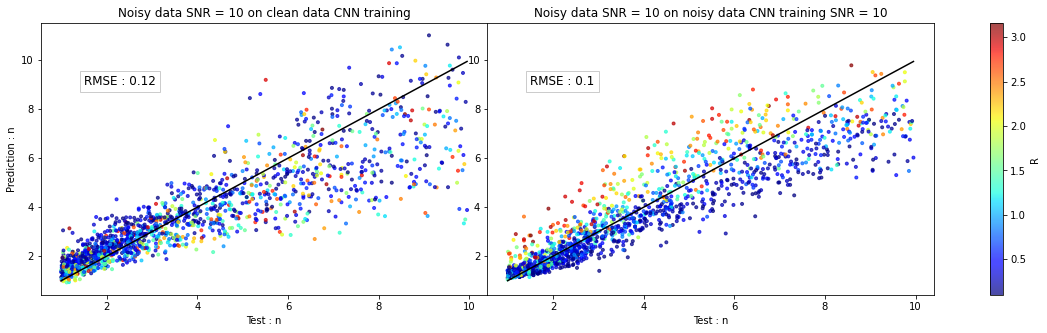

In [38]:
fig, ax =  plt.subplots(1,2, figsize = (20,5))

abscisse=np.linspace(np.min(Y_test_n[:,0])*10,np.max(Y_test_n[:,0])*10,1000)

ax[0] = plt.subplot2grid((1, 2), (0, 0), colspan=1)
ax[0].set_title("Noisy data SNR = %s on clean data CNN training"%SNR)
im = ax[0].scatter(Y_test_n[:,0]*10,Y_pred_n_snr10[:,0]*10,c=Y_test[:,0]*4,edgecolors=None,alpha=0.7,marker='.',cmap='jet')
ax[0].plot(abscisse, abscisse, 'k')
ax[0].set_xlabel('Test : n')
ax[0].set_ylabel('Prediction : n')
ax[0].text(1.5, 9, 'RMSE : %s'%np.round(rmse,2), fontsize=12,
          bbox=dict(facecolor='white', alpha=0.2))

ax[1] = plt.subplot2grid((1, 2), (0, 1), colspan=1, sharey=ax[0])
ax[1].set_title("Noisy data SNR = %s on noisy data CNN training SNR = %s"%(SNR, SNR))
im = ax[1].scatter(Y_test_n[:,0]*10,Y_pred_n_noisy10[:,0]*10,c=Y_test[:,0]*4,edgecolors=None,alpha=0.7,marker='.',cmap='jet')
ax[1].plot(abscisse, abscisse, 'k')
ax[1].set_xlabel('Test : n')
ax[1].text(1.5, 9, 'RMSE : %s'%np.round(rmse10,2), fontsize=12,
          bbox=dict(facecolor='white', alpha=0.2))


plt.subplots_adjust(wspace=0)
fig.colorbar(im, ax=ax, orientation='vertical', label='R')

#plt.savefig('images/noisy/comp_noisy_data_tant.png',dpi=100)